# Lab7: Dynamic Programming

ME C231A, EECS C220B, UC Berkeley

***

# <font color=blue> Linear CFTOC via Dynamic Programming </font>

Consider CFTOC of a discrete-time double-integrator system:
\begin{align}
\min_{\substack{ u_0,\dots,u_{N-1} \\ x_1,\dots,x_N }} ~&~ x_N^TPx_N + \displaystyle{\sum}_{k=0}^{N-1}  x_k^TQx_k + u_k^TRu_k \\
\text{subject to} ~&~ x_{k+1}=
\begin{bmatrix} 1 & 1 \\  0 & 1 \end{bmatrix}
x_k
+
\begin{bmatrix} 0 \\ 1 \end{bmatrix}
u_k \\
& -1 \leq u_k \leq 1, ~k \in \left\{ 0, \ldots, N-1 \right\} \\
& \begin{bmatrix} -15 \\ -15 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 15 \\ 15 \end{bmatrix}, ~k \in \left\{ 1, \ldots, N \right\}
\end{align}
where $N = 3$, $P = Q = \mathcal{I}_{2 \times 2}$, $R = 0.1$.

Compute the state feedback solution using the DP algorithm. The optimal state trajectory is a $2 \times (N+1)$ matrix, and the optimal control sequence is a vector of $1 \times N$. If the initial condition is infeasible, then $\texttt{xOpt}$ and $\texttt{uOpt}$ should be empty arrays. The inputs are the initial condition $\texttt{x0}$, the horizon length $\texttt{N}$, the number of grid points in each state dimension $\texttt{nXgrid}$, and the number of grid points in each input dimension $\texttt{nUgrid}$. Carefully go through the code and make sure you understand each line of code. 


For the initial point $x_0 = [-1, -1]^T$, compare the input sequence obtained from the DP solution with the one obtained with the batch solution in homework 4. Use the following parameters for your DP implementation: $\texttt{N}=3$, $\texttt{nXgrid}=100$, $\texttt{nUgrid}=21$. 
*Note:* our implementation takes approximately 1 minute to run with these parameters, run time will vary based on computer hardware differences).

In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate
import multiprocessing

pool = multiprocessing.Pool(4)

# Define system
A = np.array([[1, 1], 
              [0, 1]])
B = np.array([[0],
              [1]])
nX = 2
nU = 1

fDyn = lambda x, u : A @ np.array([x]).reshape(nX,1) + B @ np.array([u]).reshape(nU,1)

# State constraints (Box)
xmin = -15.0
xmax = 15.0

# Input constraints (Box)
umin =-1.0
umax = 1.0

# Horizon
N = 3

# Cost matrices
Q = np.eye(2)
R = np.array([0.1]).reshape(nU,nU)
PN = Q

# Create anonymous functions for Stage Cost and "optimal Cost-to-Go".
# Since the optimal cost-to-go is a function (of the state) and changes
# with time, store this as function , as dictionary. 

Jstage = lambda x, u : np.array([x]).reshape(nX,1).T @ Q @ np.array([x]).reshape(nX,1) + np.array([u]).reshape(nU,1).T @ R @ np.array([u]).reshape(nU,1)

Jopt = {}
Uopt = {}

## Grid the set X (satisfies state constraints), in state-space
nXgrid = 50
X1 = np.linspace(xmin, xmax, nXgrid)
X2 = np.linspace(xmin, xmax, nXgrid)
points = (X1, X2)

## Grid Input space
nUgrid = 21
Ugrid = np.linspace(umin, umax, nUgrid)


# Allocate memory for Jopt and Uopt arrays
# Jopt[N] is a known, quadratic function (from PN).
JoptArray = np.nan*np.zeros((nXgrid, nXgrid, N+1))
UoptArray = np.nan*np.zeros((nXgrid, nXgrid, N))
    

for idx1, x1 in enumerate(X1):
    for idx2, x2 in enumerate(X2):
        x = np.array([x1, x2]).reshape(nX, )
        JoptArray[idx1, idx2, N] = x.reshape(nX,1).T @ PN @ x.reshape(nX,1)
Jopt = lambda x, j: scipy.interpolate.interpn(points, JoptArray[:, :, j], x.flatten(), method='linear')
Uopt = lambda x, j: scipy.interpolate.interpn(points, UoptArray[:, :, j], x.flatten(), method='linear')

for j in reversed(range(N)):
    print('Computing J:', j)
    # initialize JarrayjMinus1 and uPolicy{j} matrix at this iteration
    # Loop over the 2-dimensional grid in X
    for idx1, x1 in enumerate(X1):
        for idx2, x2 in enumerate(X2):
            xi = np.array([x1, x2]).reshape(nX,)
            fun = lambda u: Jstage(xi, u).flatten() + Jopt(fDyn(xi, u),j+1).flatten()
            JBest = np.inf
            UBest = np.NaN
            # Find "minimum" over u by brute-force gridding of input space
            for uVal in Ugrid:
                xiNext = fDyn(xi, uVal)
                # Check if input choice leads to an x in X (the state constraint box)
                if np.all(xiNext>=xmin) and np.all(xiNext<=xmax):
                    Jact = fun(uVal)
                    if Jact<JBest:
                        # Record current best cost and best input
                        UBest = uVal
                        JBest = Jact
                        # Store optimal input and optimal cost at this xi-value
                        JoptArray[idx1, idx2, j] = JBest
                        UoptArray[idx1, idx2, j] = UBest

                        
x = np.array([-1, -1])
print(Jopt(x,0))

Computing J: 2
Computing J: 1
Computing J: 0
[14.18178829]


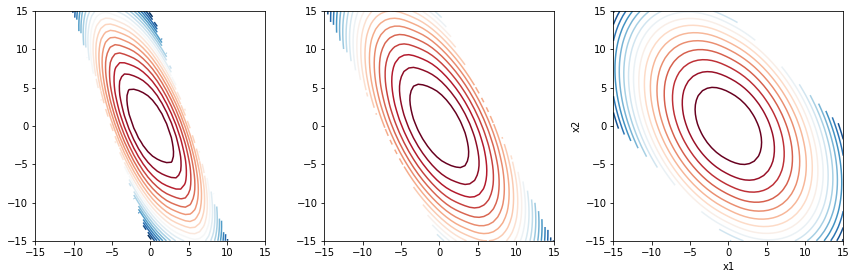

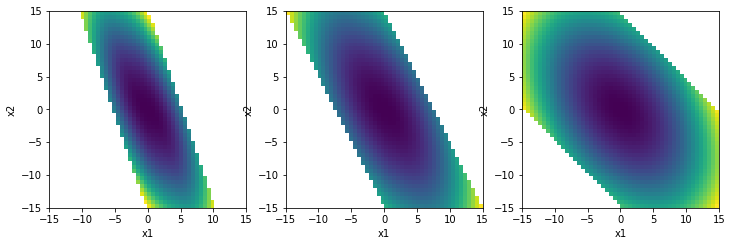

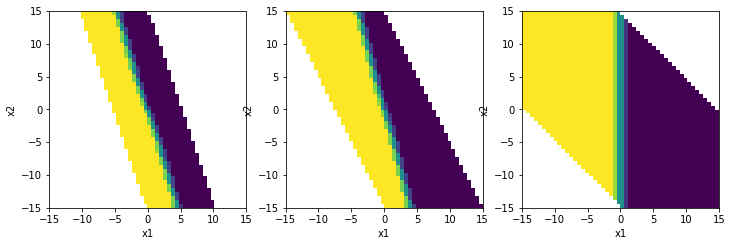

In [3]:
## Simulate from any chosen initial condition.
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(1, N, figsize=(12, 6))
for j in range(N):
    ax[j].contour(JoptArray[:,:,j], 20, cmap=cm.RdBu, extent=[-15, 15, -15, 15])
    ax[j].set_xlim(-15, 15)
    ax[j].set_ylim(-15, 15)
    ax[j].axis('square')
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig = plt.figure(figsize=(12, 6))
for j in range(N):
    ax = fig.add_subplot(1, N, j+1)
    ax.imshow(JoptArray[:,:,j], origin='lower', extent=(-15,15,-15,15))
    ax.axis([-15, 15, -15, 15])
    plt.xlabel('x1')
    plt.ylabel('x2')
    
fig = plt.figure(figsize=(12, 6))
for j in range(N):
    ax = fig.add_subplot(1, N, j+1)
    ax.imshow(UoptArray[:,:,j], origin='lower', extent=(-15,15,-15,15))
    ax.axis([-15, 15, -15, 15])
    plt.xlabel('x1')
    plt.ylabel('x2')